In [1]:
## Enable matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

## Imports
import pandas as pd
pd.set_option('mode.chained_assignment',None)
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import numpy as np
from sklearn import ensemble
from sklearn import metrics

import mytools

# General Strategy
   * Create masks to split the training and testing datasets into five distinct datasets, which will be treated differently:
       * **Polarized:** perfect record for all 5 variables, for the whole time series
       * **Basic:** perfect record for the reflectivity variables only, the polarization variables consistently missing
       * **Null:** All data points are missing for the whole time series
       * **Partial Polarized:** Contains non-null values in both reflectivity and polarization variables
       * **Partial Basic:** All polarized variables are missing, and the record for reflectivity is incomplete

In [2]:
## Read in training data
train_df = pd.read_csv('train.csv')

Start by converting the entire dataset to booleans, indicating whether or not the data is present. Put back the 'Id' column however, since it has to be used for grouping.

In [3]:
bool_df = train_df.notnull()
bool_df['Id'] = train_df['Id']

## Remove columns where the data is always present
del bool_df['minutes_past']
del bool_df['radardist_km']
del bool_df['Expected']

Create lists of columns to group the data for convenience

In [4]:
all_columns = [
    'Ref',
    'Ref_5x5_10th',
    'Ref_5x5_50th',
    'Ref_5x5_90th',
    'RefComposite',
    'RefComposite_5x5_10th',
    'RefComposite_5x5_50th',
    'RefComposite_5x5_90th',
    'RhoHV',
    'RhoHV_5x5_10th',
    'RhoHV_5x5_50th',
    'RhoHV_5x5_90th',
    'Zdr',
    'Zdr_5x5_10th',
    'Zdr_5x5_50th',
    'Zdr_5x5_90th',
    'Kdp',
    'Kdp_5x5_10th',
    'Kdp_5x5_50th',
    'Kdp_5x5_90th'
    ]

basic_columns = all_columns[:8]
polarized_columns = all_columns[8:]

## 1 - Polarized Dataset
In this section, we isolate the radar readings of the training dataset with absolutely no missing data.

### 1.1 - Create and apply the mask
We'll work from the booleanized dataset to create a mask. We'll group by 'Id', and aggregate using np.all(), which requires all entries in an array to evaluate to True. If there is even only one False, it will evaluate to False.

In [5]:
groups = bool_df.groupby('Id')
grouped = groups.agg(np.all)

We'll create a map that maps every Id to whether they are part of the polarized dataset or not, and then we'll apply this map to the training dataset to create the polarized dataset.

In [27]:
mask_map = grouped[all_columns].all(axis=1)
polarized_df = train_df[train_df['Id'].map(mask_map)]

### 1.2 - Integrate the time series
We'll integrate the reflectivities over time, by first computing time intervals associated with each entry, and then multiplying these by the reflectivities, and then grouping by summation. No substitutions are necessary in the polarized dataset. In fact, all 25 variables can be used as inputs if desired. We'll start by creating an 'interval' column in which we will compute the time interval corresponding to each reflectivity reading.

In [28]:
polarized_df['interval'] = polarized_df['minutes_past'].diff()

Then we'll try to obtain masks for the beginnings and ends of each 'Id' group, in order to treat them correctly:
   * The first interval of each group should correspond exactly to 'minutes_past'
   * The last interval of each group should correspond to 60 - last 'minutes_past' + difference

In [29]:
## Build two masks, to single out first and last rows of each group
group_begin_mask = polarized_df['Id'].diff() != 0
group_end_mask   = polarized_df['Id'].diff().shift(-1) != 0

In [30]:
## Patch the beginning entry of each group
polarized_df['interval'][group_begin_mask] = polarized_df['minutes_past'][group_begin_mask]

In [31]:
## Patch the last entry of each group
polarized_df['interval'][group_end_mask] = 60 + polarized_df['interval'][group_end_mask] - polarized_df['minutes_past'][group_end_mask]

Next, we'll calculate integrated quantities over time.

In [32]:
## Multiply the quantities by the time intervals
for var in ['Ref', 'RefComposite', 'RhoHV', 'Zdr', 'Kdp']:
    polarized_df['Int_{0}'.format(var)] = polarized_df['interval'] * polarized_df[var]

In [33]:
## Different values need to be grouped in different ways
expected  = polarized_df[['Id', 'Expected', 'radardist_km']]
expected  = expected.groupby('Id', as_index=False).first()

variables = polarized_df[['Id', 'Int_Ref', 'Int_RefComposite', 'Int_RhoHV', 'Int_Zdr', 'Int_Kdp']]
variables = variables.groupby('Id', as_index=False).sum()

In [34]:
## transform the integrated values into average values
for var in ['Int_Ref', 'Int_RefComposite', 'Int_RhoHV', 'Int_Zdr', 'Int_Kdp']:
    variables[var] = variables[var]/60.0

In [35]:
## Merge back expected and variables
polarized_df = pd.merge(variables, expected, on='Id')

In [36]:
n_polarized = len(polarized_df)
print n_polarized

90045


### 1.3 - Data cleaning

In [37]:
## A little bit of cleaning
clean_polarized_df = polarized_df.fillna(-1111.0)
clean_polarized_df = mytools.clean_stuck_gauges(clean_polarized_df, threshold=20)
clean_polarized_df = clean_polarized_df[clean_polarized_df['Expected'] < 50.0]

### 1.4 - Train the Boosted Regression Trees

In [76]:
## Extract numpy arrays to pass to scikit-learn for training
train_data   = clean_polarized_df[['radardist_km', 'Int_Ref', 'Int_RefComposite', 'Int_RhoHV', 'Int_Zdr', 'Int_Kdp']].values
train_target = clean_polarized_df['Expected'].values

In [77]:
## Train the Boosted Regression trees
polarized_brt = ensemble.GradientBoostingRegressor(max_depth=4, n_estimators=1000)
polarized_brt.fit(train_data, train_target)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [78]:
## Define function to evaluate the BRT
def predict(
    radardist_km,
    Ref,
    RefComposite,
    RhoHV,
    Zdr,
    Kdp,
    ):
    
    return polarized_brt.predict([
        radardist_km,
        Ref,
        RefComposite,
        RhoHV,
        Zdr,
        Kdp,
    ])[0]

In [79]:
## Calculate the output
polarized_df['Predicted'] = map(
    predict,
    polarized_df['radardist_km'],
    polarized_df['Int_Ref'],
    polarized_df['Int_RefComposite'],
    polarized_df['Int_RhoHV'],
    polarized_df['Int_Zdr'],
    polarized_df['Int_Kdp'],
)

### 1.5 - Visualize and evaluate

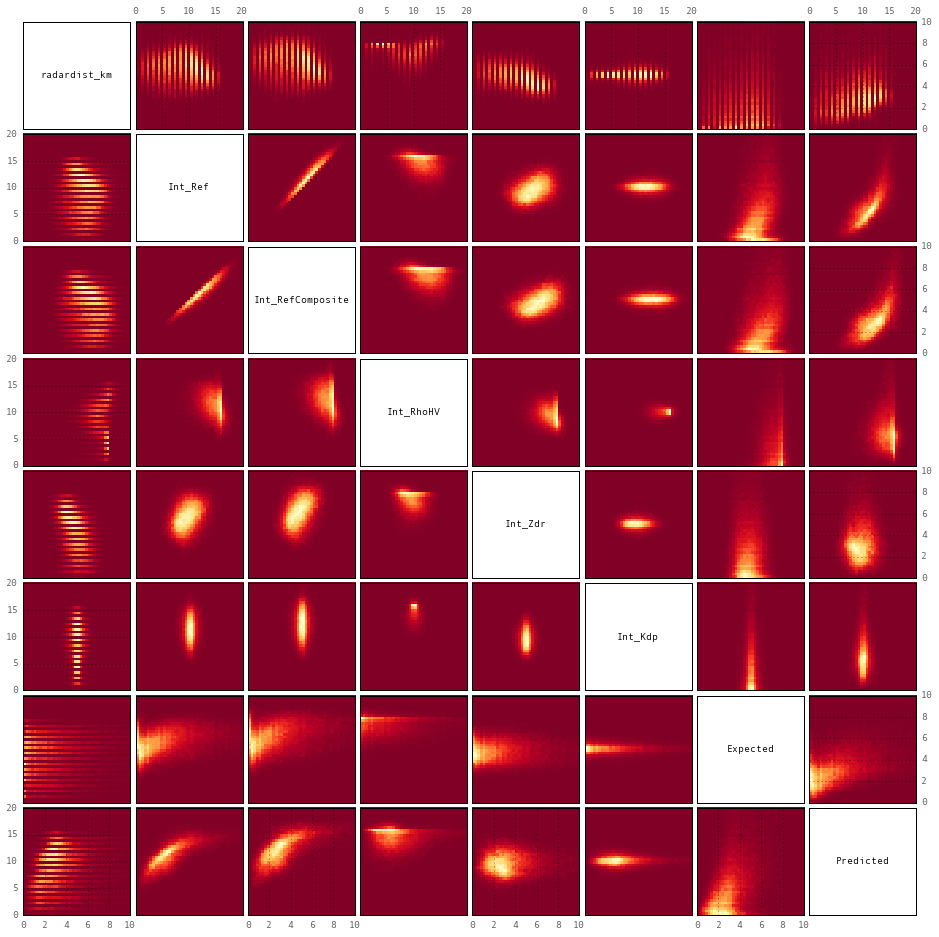

In [80]:
sm = mytools.ScatterMatrix(polarized_df)
sm.add('radardist_km', 0, 20)
sm.add('Int_Ref', 0, 50)
sm.add('Int_RefComposite', 0, 50)
sm.add('Int_RhoHV', 0.8, 1.05)
sm.add('Int_Zdr', -2,3)
sm.add('Int_Kdp', -10, 10)
sm.add('Expected', 0, 10)
sm.add('Predicted', 0, 10)
sm.plot()

In [81]:
print metrics.mean_absolute_error(polarized_df['Expected'].values, polarized_df['Predicted'].values)

9.92913140611


## 2 - Basic Dataset
In this section, we analyze the data for which we have perfect reflectivity records, but no polarization data at all.

### 2.1 - Create and apply the mask

In [ ]:
## Find rows with complete reflectivity data
groups = bool_df[['Id'] + basic_columns].groupby('Id')
grouped = groups.agg(np.all)

In [ ]:
basic_mask_map = grouped[basic_columns].all(axis=1)

In [ ]:
## Find rows without any polarization data
groups = bool_df[['Id'] + polarized_columns].groupby('Id')
grouped = groups.agg(np.any)

In [ ]:
polarized_mask_map = ~grouped[polarized_columns].any(axis=1)

In [ ]:
mask_map = basic_mask_map & polarized_mask_map

In [ ]:
basic_df = train_df[train_df['Id'].map(mask_map)]

In [ ]:
## Drop the polarization columns
for col in polarized_columns:
    del basic_df[col]

### 2.2 - Integrate the time series

In [ ]:
## -------------------------------------------
def intervals(df):
    """
    Adds a column to the dataframe assigning a time interval for each entry
    """
    
    df['interval'] = df['minutes_past'].diff()
    
    ## Build two masks, to single out first and last rows of each group
    group_begin_mask = df['Id'].diff() != 0
    group_end_mask   = df['Id'].diff().shift(-1) != 0
    
    ## Patch the beginning entry of each group
    df['interval'][group_begin_mask] = df['minutes_past'][group_begin_mask]
    
    ## Patch the last entry of each group
    df['interval'][group_end_mask] = 60 + df['interval'][group_end_mask] - df['minutes_past'][group_end_mask]

In [ ]:
intervals(basic_df)

In [ ]:
## -------------------------------------------
def integrated_mean(df, columns=['Ref', 'RefComposite', 'RhoHV', 'Zdr', 'Kdp']):
    """
    Uses the time intervals computed with intervals() to calculate a mean from integration
    """
    
    int_columns = []
    
    ## Multiply the quantities by the time intervals
    for var in columns:
        name = 'Int_{0}'.format(var)
        df[name] = df['interval'] * df[var]
        int_columns.append(name)
        
    ## Different values need to be grouped in different ways
    expected  = df[['Id', 'Expected', 'radardist_km']]
    expected  = expected.groupby('Id', as_index=False).mean()

    variables = df[['Id'] + int_columns]
    variables = variables.groupby('Id', as_index=False).sum()
    
    ## transform the integrated values into average values
    for var in int_columns:
        variables[var] = variables[var]/60.0
        
    ## Merge back expected and variables
    return pd.merge(variables, expected, on='Id')

In [ ]:
basic_df = integrated_mean(basic_df, ['Ref', 'RefComposite'])

In [ ]:
n_basic = len(basic_df)
print n_basic

### 2.3 - Data cleaning

In [ ]:
## A little bit of cleaning
## -------------------------------------------
def clean(df):
    """
    Cleaning the data before training
    """
    
    clean_df = df.fillna(-1111.0)
    clean_df = mytools.clean_stuck_gauges(clean_df, threshold=20)
    clean_df = clean_df[clean_df['Expected'] < 50.0]
    
    return clean_df

In [ ]:
clean_basic_df = clean(basic_df)

### 2.4 - Train the Boosted Regression Trees

In [ ]:
## Extract numpy arrays to pass to scikit-learn for training
train_data   = clean_basic_df[['radardist_km', 'Int_Ref', 'Int_RefComposite']].values
train_target = clean_basic_df['Expected'].values

In [ ]:
## Train the Boosted Regression trees
basic_brt = ensemble.GradientBoostingRegressor(max_depth=4, n_estimators=1000)
basic_brt.fit(train_data, train_target)

In [ ]:
## Define function to evaluate the BRT
def basic_predict(
    radardist_km,
    Ref,
    RefComposite
    ):
    
    return basic_brt.predict([
        radardist_km,
        Ref,
        RefComposite
    ])[0]

In [ ]:
## Calculate the output
basic_df['Predicted'] = map(
    basic_predict,
    basic_df['radardist_km'],
    basic_df['Int_Ref'],
    basic_df['Int_RefComposite']
)

### 2.5 - Visualize and evaluate

In [ ]:
sm = mytools.ScatterMatrix(basic_df)
sm.add('radardist_km', 0, 20)
sm.add('Int_Ref', 0, 50)
sm.add('Int_RefComposite', 0, 50)
sm.add('Expected', 0, 20)
sm.add('Predicted', 0, 20)
sm.plot()

In [ ]:
print metrics.mean_absolute_error(basic_df['Expected'].values, basic_df['Predicted'].values)

## 3 - Null Dataset

In [ ]:
## Find rows with any column filled
groups = bool_df[['Id'] + all_columns].groupby('Id')
grouped = groups.agg(np.any)

In [ ]:
mask_map = ~grouped[all_columns].any(axis=1)

In [ ]:
null_df = train_df[train_df['Id'].map(mask_map)]

In [ ]:
null_df = null_df.groupby('Id').mean()

In [ ]:
n_null = len(null_df)
print n_null

In [ ]:
for col in all_columns:
    del null_df[col]

In [ ]:
null_prediction = null_df['Expected'].median()
print null_prediction

In [ ]:
## Calculate the output
null_df['Predicted'] = null_prediction

In [ ]:
print metrics.mean_absolute_error(null_df['Expected'].values, null_df['Predicted'].values)

## 4 - Partial Polarized and Partial Basic Datasets

### 4.1 - Create and apply the masks

In [ ]:
## Find at least one entry in the reflectivity columns, but not all
groups = bool_df[['Id'] + basic_columns].groupby('Id')
any_grouped = groups.agg(np.any)
all_grouped = groups.agg(np.all)

print len(groups)

In [ ]:
basic_any_mask_map = any_grouped[basic_columns].any(axis=1)
basic_all_mask_map = all_grouped[basic_columns].all(axis=1)

In [ ]:
basic_mask_map = basic_any_mask_map & ~basic_all_mask_map

In [ ]:
groups = bool_df[['Id'] + polarized_columns].groupby('Id')
any_grouped = groups.agg(np.any)
all_grouped = groups.agg(np.all)

In [ ]:
polarized_any_mask_map = any_grouped[polarized_columns].any(axis=1)
polarized_all_mask_map = all_grouped[all_columns].all(axis=1)

In [ ]:
polarized_mask_map = polarized_any_mask_map & ~polarized_all_mask_map

In [ ]:
partial_polarized_df = train_df[train_df['Id'].map(polarized_mask_map)]

In [ ]:
partial_basic_df = train_df[train_df['Id'].map(basic_mask_map & ~polarized_any_mask_map)]

In [ ]:
## Drop the polarization columns
for col in polarized_columns:
    del partial_basic_df[col]

### 4.2 -  Integrate the time series

In [ ]:
intervals(partial_basic_df)

In [ ]:
intervals(partial_polarized_df)

In [ ]:
## Complete data
cf = {
    'Ref' : (1.01, 1.19, 0.86),
    'RefComposite' : (1.01, 1.15, 0.87),
    'RhoHV' : (1.00, 1.05, 0.97)
}

## -------------------------------------------
def complete(df, columns=[]):
    """
    Completes the main variables using the distributions
    """
    
    for var in columns:
        df[var] = cf[var][0]*df[var].fillna(value=df['{0}_5x5_50th'.format(var)])
        df[var] = cf[var][1]*df[var].fillna(value=df['{0}_5x5_10th'.format(var)])
        df[var] = cf[var][2]*df[var].fillna(value=df['{0}_5x5_90th'.format(var)])
    
        del df['{0}_5x5_10th'.format(var)]
        del df['{0}_5x5_50th'.format(var)]
        del df['{0}_5x5_90th'.format(var)]

In [ ]:
complete(partial_basic_df, ['Ref', 'RefComposite'])
complete(partial_polarized_df, ['Ref', 'RefComposite', 'RhoHV'])

In [ ]:
partial_basic_df = integrated_mean(partial_basic_df, ['Ref', 'RefComposite'])
partial_polarized_df = integrated_mean(partial_polarized_df, ['Ref', 'RefComposite', 'RhoHV', 'Zdr', 'Kdp'])

In [ ]:
n_partial_polarized = len(partial_polarized_df)
n_partial_basic = len(partial_basic_df)
print n_partial_polarized, n_partial_basic

print n_polarized + n_basic + n_null + n_partial_polarized + n_partial_basic

### 4.3 - Data cleaning

In [ ]:
clean_partial_basic_df = clean(partial_basic_df)
clean_partial_polarized_df = clean(partial_polarized_df)

### 4.4 - Train the Boosted Regression Trees (Basic)

In [ ]:
## Extract numpy arrays to pass to scikit-learn for training
train_data   = clean_partial_basic_df[['radardist_km', 'Int_Ref', 'Int_RefComposite']].values
train_target = clean_partial_basic_df['Expected'].values

In [ ]:
## Train the Boosted Regression trees
partial_basic_brt = ensemble.GradientBoostingRegressor(max_depth=4, n_estimators=1000)
partial_basic_brt.fit(train_data, train_target)

In [ ]:
## Define function to evaluate the BRT
def partial_basic_predict(
    radardist_km,
    Ref,
    RefComposite
    ):
    
    return partial_basic_brt.predict([
        radardist_km,
        Ref,
        RefComposite
    ])[0]

In [ ]:
## Calculate the output
partial_basic_df = partial_basic_df.fillna(-1111.0)
partial_basic_df['Predicted'] = map(
    partial_basic_predict,
    partial_basic_df['radardist_km'],
    partial_basic_df['Int_Ref'],
    partial_basic_df['Int_RefComposite']
)

### 4.5 - Visualize and evaluate (Basic)

In [ ]:
sm = mytools.ScatterMatrix(partial_basic_df)
sm.add('radardist_km', 0, 20)
sm.add('Int_Ref', 0, 50)
sm.add('Int_RefComposite', 0, 50)
sm.add('Expected', 0, 20)
sm.add('Predicted', 0, 20)
sm.plot()

In [ ]:
print metrics.mean_absolute_error(partial_basic_df['Expected'].values, partial_basic_df['Predicted'].values)

### 4.6 - Train the Boosted Regression Trees (Polarized)

In [ ]:
## Extract numpy arrays to pass to scikit-learn for training
train_data   = clean_partial_polarized_df[['radardist_km', 'Int_Ref', 'Int_RefComposite', 'Int_RhoHV', 'Int_Zdr', 'Int_Kdp']].values
train_target = clean_partial_polarized_df['Expected'].values

In [ ]:
## Train the Boosted Regression trees
partial_polarized_brt = ensemble.GradientBoostingRegressor(max_depth=4, n_estimators=1000)
partial_polarized_brt.fit(train_data, train_target)

In [ ]:
## Define function to evaluate the BRT
def partial_polarized_predict(
    radardist_km,
    Ref,
    RefComposite,
    RhoHV,
    Zdr,
    Kdp,
    ):
    
    return partial_polarized_brt.predict([
        radardist_km,
        Ref,
        RefComposite,
        RhoHV,
        Zdr,
        Kdp,
    ])[0]

In [ ]:
## Calculate the output
partial_polarized_df = partial_polarized_df.fillna(-1111.0)
partial_polarized_df['Predicted'] = map(
    partial_polarized_predict,
    partial_polarized_df['radardist_km'],
    partial_polarized_df['Int_Ref'],
    partial_polarized_df['Int_RefComposite'],
    partial_polarized_df['Int_RhoHV'],
    partial_polarized_df['Int_Zdr'],
    partial_polarized_df['Int_Kdp'],
)

### 5.7 - Visualize and evaluate (Polarized)

In [ ]:
sm = mytools.ScatterMatrix(partial_polarized_df)
sm.add('radardist_km', 0, 20)
sm.add('Int_Ref', 0, 50)
sm.add('Int_RefComposite', 0, 50)
sm.add('Int_RhoHV', 0.8, 1.05)
sm.add('Int_Zdr', -2,3)
sm.add('Int_Kdp', -10, 10)
sm.add('Expected', 0, 10)
sm.add('Predicted', 0, 10)
sm.plot()

In [ ]:
print metrics.mean_absolute_error(partial_polarized_df['Expected'].values, partial_polarized_df['Predicted'].values)